# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [8]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', '\t')
except:
    data = pd.read_csv('real_estate_data.csv', '\t')
pd.set_option('display.max_columns', None)
data.head() 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
data = data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest', 
                            'parks_around3000':'parks_around_three_km',
                            'ponds_around3000':'ponds_around_three_km'})

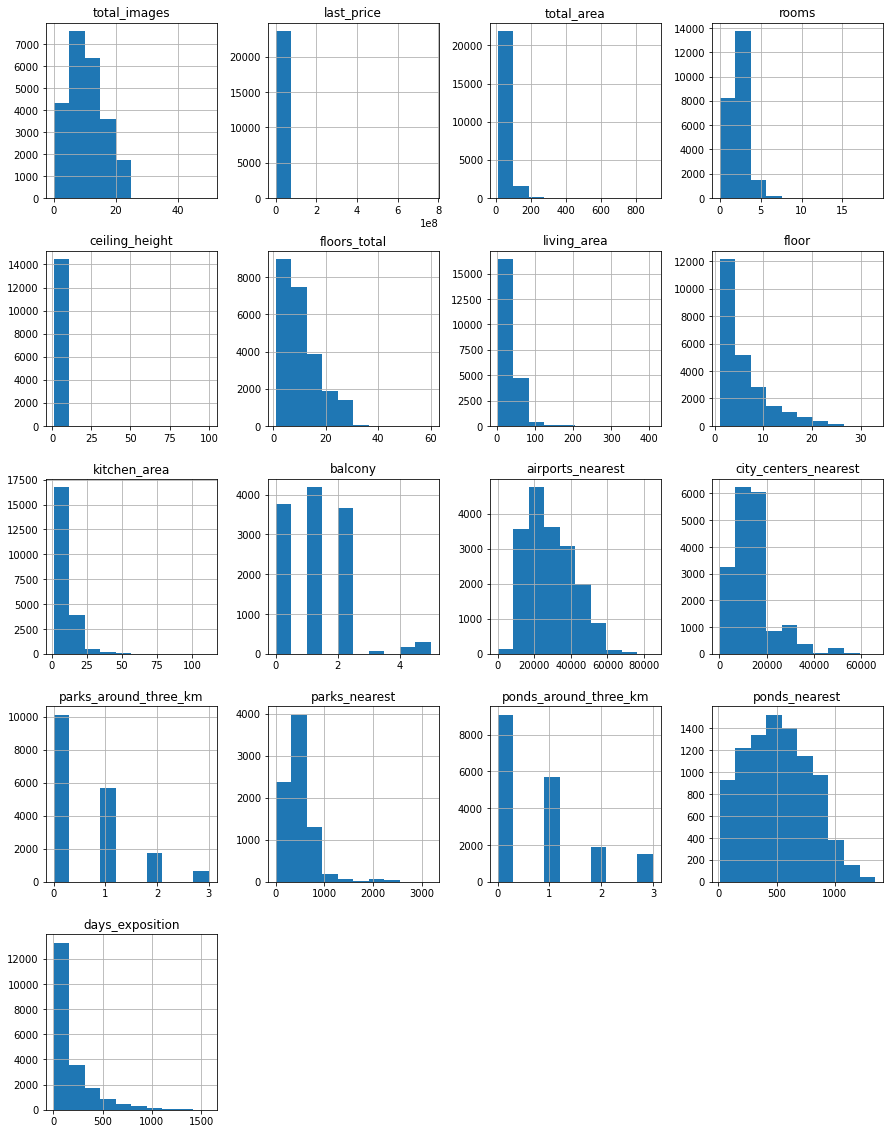

In [4]:
data.hist(figsize=(15,20));

**В данных имеется 23699 объекта**
<br>**~Из основной информации видно, что есть проблемы с большим количеством пропусков. Из 22 фичей, только в 8 нет пропусков.**
<br>**~Так же есть не оптимизированные типы данных и типы данных, которые стоит изменить (прим. is_apartment)**
<br>**~Если посмотреть на них с высока можно понять, что тут 1 временной тип данных(first_day_exposition) и 4 категориальных(locality_name, open_plan, studio, is_apartment), все остальные количественные**
<br>**~Так же по графикам видно, что есть резкие перепады, что говорит, о том, что есть аномалии и редкие значчения, которые не помогут проанализировать картину в целом**

### Предобработка данных

#### Поиск пропущенных значений и их обработка

In [5]:
data.isna().sum()

total_images                 0
last_price                   0
total_area                   0
first_day_exposition         0
rooms                        0
ceiling_height            9195
floors_total                86
living_area               1903
floor                        0
is_apartment             20924
studio                       0
open_plan                    0
kitchen_area              2278
balcony                  11519
locality_name               49
airports_nearest          5542
city_centers_nearest      5519
parks_around_three_km     5518
parks_nearest            15620
ponds_around_three_km     5518
ponds_nearest            14589
days_exposition           3181
dtype: int64

**Обрабатываем пропуски. (Если бы были типовые серии домов, то можно было бы намного больше пропусков заменить)**
<br>1) ceiling_height - высоту потолков изменим на медиану
<br>2) floors_total - с количеством этажей тоже не обмануть
<br>3) living_area - живая площадь, с ней тоже ничего не поделать
<br>4) is_apartment - апартаменты ли? можно предположить, что пустоты тоже False, раз не указаны
<br>5) kitchen_area - площадь кухни, как и жилая площадь для нас остается загадкой
<br>6) balcony - балконы, как и апарты сделаем их отсутствие, раз не указаны (хотя кто их знает, вдруг там лоджии)
<br>7) locality_name - населенный пункт вообще не угадать
<br>8) airports_nearest - ближайший аэропорт, без адреса и не узнать, не трогаем
<br>9) city_centers_nearest - расстояние до центра города, без адреса и не узнать, не трогаем
<br>10) parks_around_three_km - парк в радиусе 3 км, без адреса и не узнать, не трогаем
<br>11) parks_nearest - ближайший парк, без адреса и не узнать, не трогаем
<br>12) ponds_around_three_km - водоемы в радиусе 3 км, без адреса и не узнать, не трогаем
<br>13) ponds_nearest - ближайший водоем, без адреса и не узнать, не трогаем
<br>14) days_exposition - дни в работе, без информации с ИС не узнать

In [6]:
# заполним пропуски "is_apartment"
data['is_apartment'] = data['is_apartment'].fillna(False)

In [7]:
# заполним пропуски "balcony"
data['balcony'] = data['balcony'].fillna(0)

In [8]:
# заполним пропуски "ceiling_height"
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

**Есть пара фичей, которые имеют мало пропусков, поэтому, как у врачей, если убрать данных не более 5%, то на общую температуру в палате особо роли не сыграет**

In [9]:
# Грубо проверим, а не превысим ли мы 5%, делая вид, что пропуски только в уникальных строках
(data['floors_total'].isna().sum() + data['locality_name'].isna().sum())  / data.shape[0] * 100

0.5696442887885564

**Похоже на то, что можно попрощаться с этими строками**

In [10]:
# Удаляем строки, где мало пропусков
data = data.dropna(subset=['floors_total', 'locality_name'])

In [11]:
# Для наглядности еще раз выведем info
data.info()
d_memory = data.memory_usage().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_images           23565 non-null  int64  
 1   last_price             23565 non-null  float64
 2   total_area             23565 non-null  float64
 3   first_day_exposition   23565 non-null  object 
 4   rooms                  23565 non-null  int64  
 5   ceiling_height         23565 non-null  float64
 6   floors_total           23565 non-null  float64
 7   living_area            21700 non-null  float64
 8   floor                  23565 non-null  int64  
 9   is_apartment           23565 non-null  bool   
 10  studio                 23565 non-null  bool   
 11  open_plan              23565 non-null  bool   
 12  kitchen_area           21343 non-null  float64
 13  balcony                23565 non-null  float64
 14  locality_name          23565 non-null  object 
 15  ai

#### Обработка типов данных

**Преобразуем все типы данных, которые нам не нравятся**
<br>**В некоторых данных понижу разряд, для повышения скорости обработки данных, если данных станет гораздо больше**

In [12]:
# немного понизим разряд
data = data.astype({'total_images':'uint8', 
                    'last_price':'uint32', 
                    'total_area':'float32', 
                    'rooms':'uint8', 
                    'ceiling_height':'float32', 
                    'floors_total':'uint8', 
                    'living_area':'float32',
                    'floor':'uint8', 
                    'kitchen_area':'float32', 
                    'balcony':'uint8', 
                    'days_exposition':'uint32'}, errors='ignore') 
# дата есть дата !
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])

# список преобразования (умнее обойти ошибку с NaN не смог)
list_name = ['airports_nearest','city_centers_nearest', 
             'parks_around_three_km', 'parks_nearest', 
             'ponds_around_three_km', 'ponds_nearest',
            'days_exposition']

# до сантиметров надеюсь считать никто не будет
for name in list_name:
    data[name] = pd.array(data[name], dtype='float32')

new_d_memory = data.memory_usage().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   total_images           23565 non-null  uint8         
 1   last_price             23565 non-null  uint32        
 2   total_area             23565 non-null  float32       
 3   first_day_exposition   23565 non-null  datetime64[ns]
 4   rooms                  23565 non-null  uint8         
 5   ceiling_height         23565 non-null  float32       
 6   floors_total           23565 non-null  uint8         
 7   living_area            21700 non-null  float32       
 8   floor                  23565 non-null  uint8         
 9   is_apartment           23565 non-null  bool          
 10  studio                 23565 non-null  bool          
 11  open_plan              23565 non-null  bool          
 12  kitchen_area           21343 non-null  float32       
 13  b

In [13]:
print(f'Сократили объем используемой памяти на {round(new_d_memory / d_memory  * 100,1)}%\nЭто ли не чудо!')
# в процентах, чтобы было выглядило красиво, а то на пара мб так себе звучит =)

Сократили объем используемой памяти на 49.1%
Это ли не чудо!


#### Рассмотрим уникальные значения и расправимся с повторяющимися в названиях

In [14]:
locality_name_unique = data['locality_name'].sort_values().unique()
print(f'Уникальные навзания: \n{locality_name_unique}\n')
count_name = locality_name_unique.shape[0]
print(f'Уникальных значений: {count_name}')

Уникальные навзания: 
['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Свирьстрой'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатово' 'деревня Аро'
 'деревня Батово' 'дер

**Можно заметить однозначные названия (прим. "поселок городского типа" == "гордской поселок")**
<br>**Так же сомнительный характер несет буква "ё"**

In [15]:
# постепенно вносим изменения и смотрим на результат
# начнем с понижения регистра
data['locality_name'] = data['locality_name'].str.lower() 
locality_name_unique = data['locality_name'].sort_values().unique()
new_count_name = locality_name_unique.shape[0]
if new_count_name == count_name:
    print('Изменений не произошло!')
else:
    print(f'Есть реакция! Теперь уникальных значений: {new_count_name} ')
    count_name = new_count_name

Изменений не произошло!


In [16]:
# теперь посмотрим на Ё и Е    
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
locality_name_unique = data['locality_name'].sort_values().unique()
new_count_name = locality_name_unique.shape[0]
if new_count_name == count_name:
    print('Изменений не произошло!')
else:
    print(f'Есть реакция! Теперь уникальных значений: {new_count_name} ')
    count_name = new_count_name

Есть реакция! Теперь уникальных значений: 330 


In [17]:
# теперь изменим поселок городского типа
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
locality_name_unique = data['locality_name'].sort_values().unique()
new_count_name = locality_name_unique.shape[0]
if new_count_name == count_name:
    print('Изменений не произошло!')
else:
    print(f'Есть реакция! Теперь уникальных значений: {new_count_name} ')
    count_name = new_count_name

Есть реакция! Теперь уникальных значений: 323 


In [18]:
# еще раз взглянем
locality_name_unique = data['locality_name'].sort_values().unique()
print(f'Уникальные навзания: \n{locality_name_unique}\n')
print(f'Уникальных значений: {locality_name_unique.shape[0]}')

Уникальные навзания: 
['бокситогорск' 'волосово' 'волхов' 'всеволожск' 'выборг' 'высоцк'
 'гатчина' 'деревня агалатово' 'деревня аро' 'деревня батово'
 'деревня бегуницы' 'деревня белогорка' 'деревня большая вруда'
 'деревня большая пустомержа' 'деревня большие колпаны'
 'деревня большое рейзино' 'деревня большой сабск' 'деревня бор'
 'деревня борисова грива' 'деревня ваганово' 'деревня вартемяги'
 'деревня вахнова кара' 'деревня выскатка' 'деревня гарболово'
 'деревня глинка' 'деревня горбунки' 'деревня гостилицы'
 'деревня заклинье' 'деревня заневка' 'деревня зимитицы' 'деревня извара'
 'деревня иссад' 'деревня калитино' 'деревня кальтино' 'деревня камышовка'
 'деревня каськово' 'деревня келози' 'деревня кипень' 'деревня кисельня'
 'деревня колтуши' 'деревня коркино' 'деревня котлы' 'деревня кривко'
 'деревня кудрово' 'деревня кузьмолово' 'деревня курковицы'
 'деревня куровицы' 'деревня куттузи' 'деревня лаврики' 'деревня лаголово'
 'деревня лампово' 'деревня лесколово' 'деревня лопу

**Поговорим о дубликатах**

In [19]:
print('Количетво явных дубликатов:', data.duplicated().sum())

Количетво явных дубликатов: 0


**Везение, система не принимает одинаковую недвижимость**

#### Рассмотрим аномалии и редкие значения

In [20]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_three_km,parks_nearest,ponds_around_three_km,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,21700.000000,23565.000000,21343.000000,23565.000000,18041.000000,18064.000000,18065.000000,8030.000000,18065.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322826,2.070656,2.724530,10.675875,34.454823,5.878124,10.560994,0.593677,28797.082031,14192.656250,0.611569,490.580444,0.769499,518.289490,180.741394
std,5.681156,1.091093e+07,35.657059,1.078591,0.991026,6.594823,22.045359,4.871485,5.900630,0.960660,12632.500000,8613.348633,0.802088,341.572968,0.938669,278.009552,219.732788
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26757.000000,13096.500000,0.000000,455.000000,1.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.699997,3.000000,2.700000,16.000000,42.299999,8.000000,12.000000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700012,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**И начнем рассматривать все столбцы**

**1) С количеством фотографий ничего не поделаешь**

**2) А вот с последней ценой есть непорядок, в частности в минимуме**

In [21]:
# Рассмотрим по подробнее
data['last_price'].sort_values() 

8793         12190
17456       430000
14911       430000
16274       440000
9581        450000
           ...    
15651    300000000
1436     330000000
14706    401300000
19540    420000000
12971    763000000
Name: last_price, Length: 23565, dtype: uint32

**Есть очень маленькое значение, скорее всего ошибка в отсутсвии пары нулей**

In [22]:
data[data['last_price'] < 10000000]['locality_name'].unique()

array(['поселок шушары', 'санкт-петербург',
       'поселок городского типа янино-1', 'поселок парголово',
       'поселок мурино', 'ломоносов', 'сертолово', 'петергоф', 'пушкин',
       'деревня кудрово', 'коммунар', 'колпино',
       'поселок городского типа красный бор', 'гатчина',
       'деревня федоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'поселок металлострой',
       'поселок городского типа лебяжье',
       'поселок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'деревня пикколово',
       'всеволожск', 'волхов', 'кингисепп', 'приозерск', 'сестрорецк',
       'деревня куттузи', 'поселок аннино',
       'поселок городского типа ефимовский', 'поселок плодовое',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'поселок понтонный', 'сясьстрой', 'деревня старая',
       'павловск', 'деревня лесколово', 'посел

**Недвижимость до миллиона находятся в деревнях, возможно так и есть**
<br>**Кроме одного, как раз с минимальной суммой**

In [23]:
data[data['last_price'] < 100000]['locality_name']

8793    санкт-петербург
Name: locality_name, dtype: object

In [24]:
# изменим ее стоимость
data.update(data[data['last_price'] < 100000]['last_price'] * 1000)

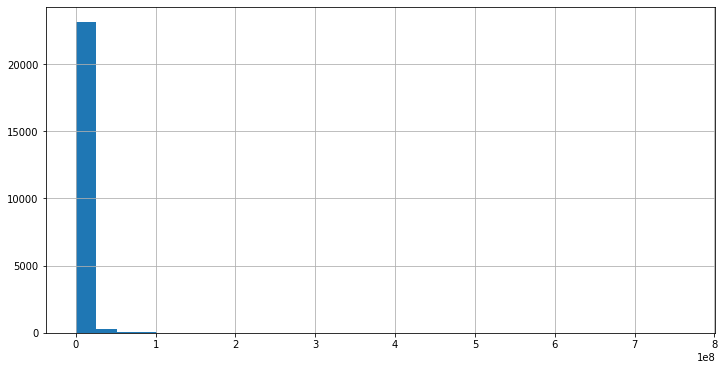

In [25]:
data['last_price'].hist(figsize=(12,6),bins=30);

In [26]:
# по графику видно, что после 100м недвижимость идет в штучном экземпляре
data[data['last_price'] > 100_000_000]['last_price'].count()

37

**Так оно и есть, можем избавиться**

In [27]:
data.drop(data.query('last_price > 100_000_000').index,inplace=True)

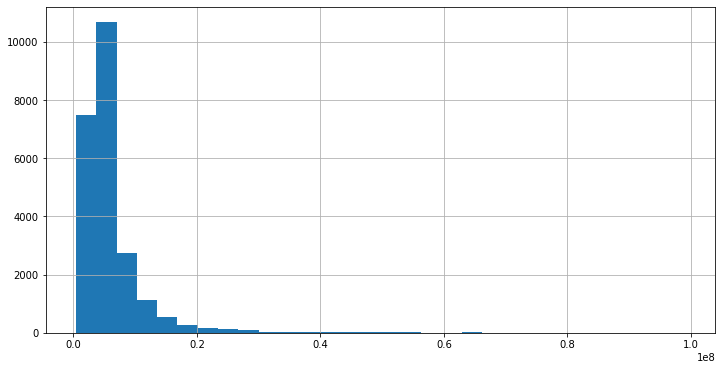

In [28]:
data['last_price'].hist(figsize=(12,6),bins=30);

**3) Минимальная площадь 12 кв, и такое существует, но рассмотрим по подробнее**

In [29]:
data[data['total_area'] < 20]['total_area'].count()

27

**Количество недвижимости меньше 20 квадратов, слишком маленькое**

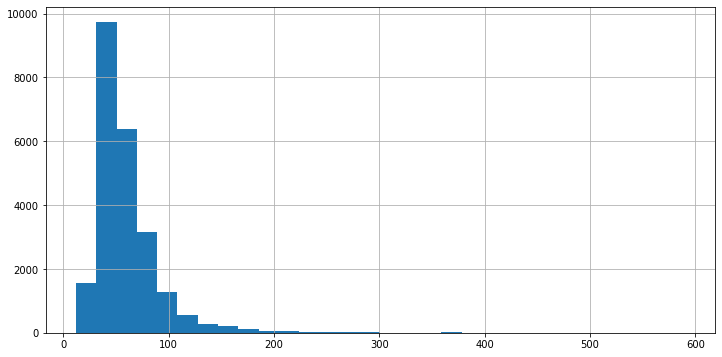

In [30]:
data['total_area'].hist(figsize=(12,6),bins=30);

**По графику так же можно заметить, что свыше 300 кв, тоже мало объявлений**

In [31]:
data[data['total_area'] > 300]['total_area'].count()

45

**Можно так же убрать из выборки для анализа**

In [32]:
data.drop(data.query('total_area < 20 or total_area > 300').index,inplace=True)

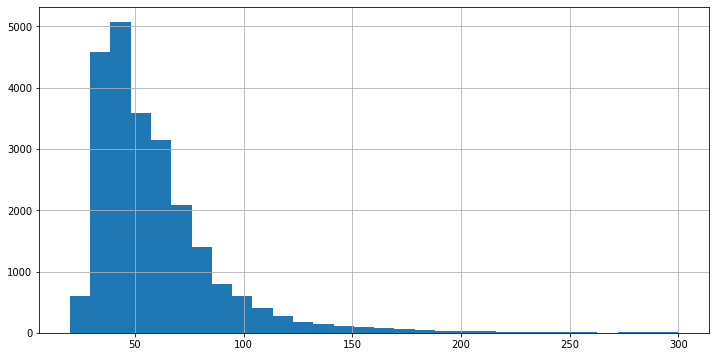

In [33]:
data['total_area'].hist(figsize=(12,6),bins=30);

**4) Теперь поговорим про количество комнат, есть недвижимость, где комнат 0**

In [34]:
data[data['rooms'] == 0]['studio'].sum()

128

**Большая часть это студии, возможно, у некоторых не указан тип или это апартаменты**

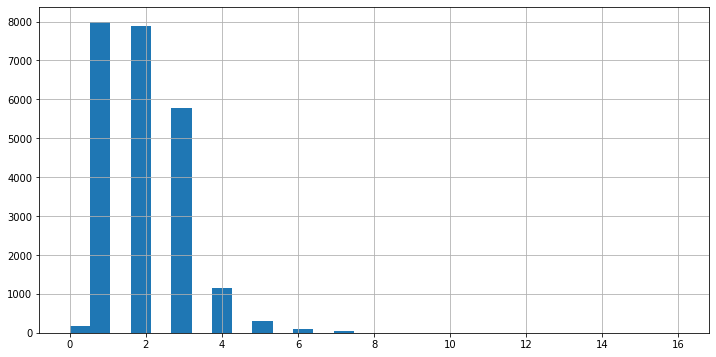

In [35]:
data['rooms'].hist(figsize=(12,6),bins=30);

**По графику видно, что свыше 7 комнат, уже маленькое количество, тоже отсечем**

In [36]:
data.drop(data.query('rooms > 7').index,inplace=True)

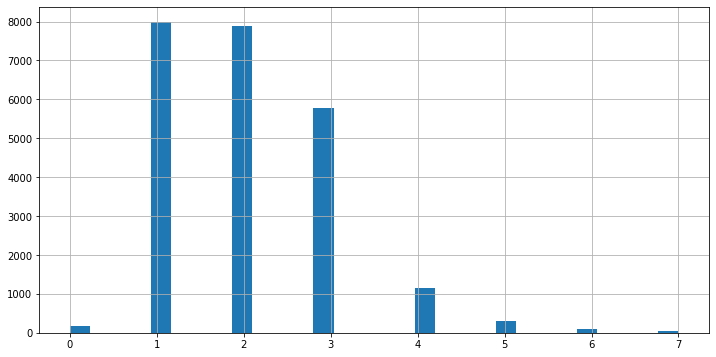

In [37]:
data['rooms'].hist(figsize=(12,6),bins=30);

**5) Теперь самое веселое, высота потолков**
<br>**Значения самые разные, от метра до 100**

In [38]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,   3.5 ,
      

**Значения с высотой от 2 до 4 метров скорее всего ошибка в данных, в частности в запятой**

In [39]:
# изменим высоты
data.update(data[(data['ceiling_height'] >= 20) & (data['ceiling_height'] <= 40)]['ceiling_height'] / 10)

In [40]:
# высоты меньше 2 м и больше 5 м будем считать аномальными, поэтому избавимся
data.drop(data.query('ceiling_height < 2 or ceiling_height > 5').index,inplace=True)

In [41]:
# взглянем еще раз, выглядит уже лучше
data['ceiling_height'].sort_values().unique()

array([2.  , 2.2 , 2.25, 2.26, 2.3 , 2.34, 2.4 , 2.45, 2.46, 2.47, 2.48,
       2.49, 2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59,
       2.6 , 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 ,
       2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81,
       2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92,
       2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.02, 3.03,
       3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14,
       3.15, 3.16, 3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26,
       3.27, 3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37,
       3.38, 3.39, 3.4 , 3.42, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 ,
       3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62,
       3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 ,
       3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95, 3.98, 4.  ,
       4.06, 4.1 , 4.14, 4.15, 4.19, 4.2 , 4.25, 4.

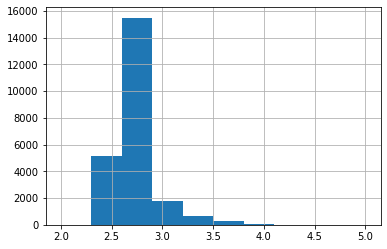

In [42]:
data['ceiling_height'].hist();

**6) Наступает черед количества этажей**

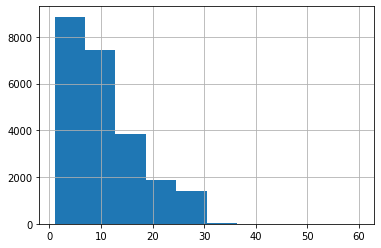

In [43]:
data['floors_total'].hist();

**Этажей больше 40 в целом не много, можно отбросить**

In [44]:
data.drop(data.query('floors_total > 40').index,inplace=True)

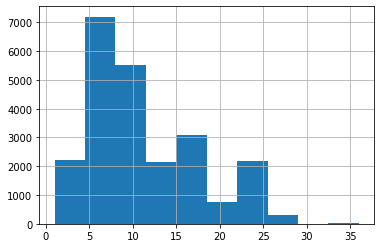

In [45]:
data['floors_total'].hist();

**7) Рассмотрим жилую площадь**

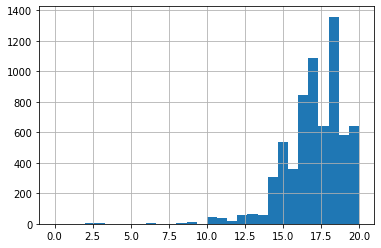

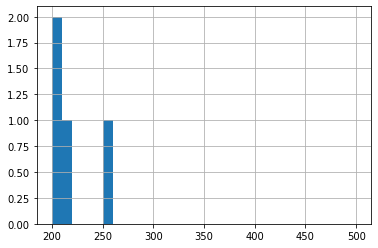

In [46]:
data['living_area'].hist(bins=30,range=(0,20))
plt.show()
data['living_area'].hist(bins=30,range=(200, 500))
plt.show()

**Квартиры с жилой площадью меньше 10 кв и больше 250 имеют слишком маленькую выборку для анализа**
<br>**Удаляем**

In [47]:
data.drop(data.query('living_area < 10 or living_area > 250').index,inplace=True)

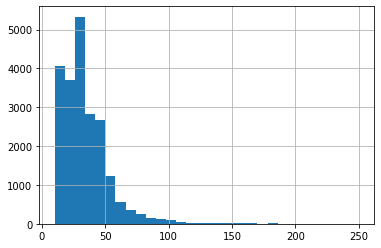

In [48]:
data['living_area'].hist(bins=30);

**8) Номер этажа**

In [49]:
data['floor'].unique()

array([ 8,  1,  4,  9, 13,  5,  6, 22, 26,  7,  3,  2, 11, 15, 18, 10, 19,
       16, 20, 27, 25, 17, 14, 12, 21, 28, 24, 23, 30, 29, 32, 33, 31],
      dtype=uint8)

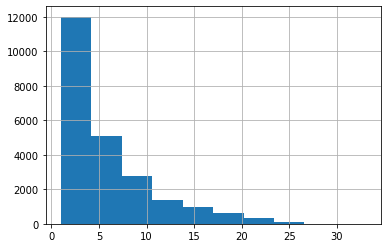

In [50]:
data['floor'].hist();

**Не добавить, не убавить**

**9) Площадь кухни**

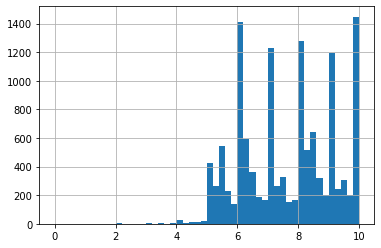

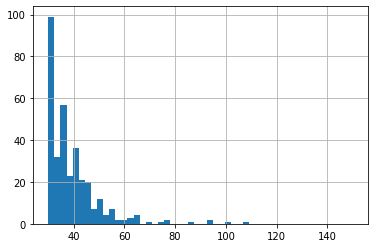

In [51]:
data['kitchen_area'].hist(bins=50,range=(0,10))
plt.show()
data['kitchen_area'].hist(bins=50,range=(30, 150))
plt.show()

**Квартиры с кухней меньше 2 кв и больше 110 имеют слишком маленькую выборку для анализа**
<br>**Удаляем**

In [52]:
data.drop(data.query('kitchen_area < 2 or kitchen_area > 110').index,inplace=True)

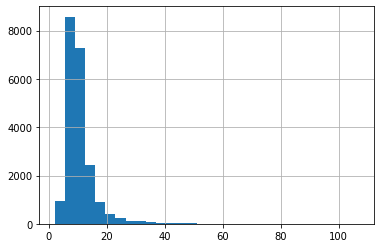

In [53]:
data['kitchen_area'].hist(bins=30);

**10) Балконы**

In [54]:
data['balcony'].unique()

array([0, 2, 1, 5, 4, 3], dtype=uint8)

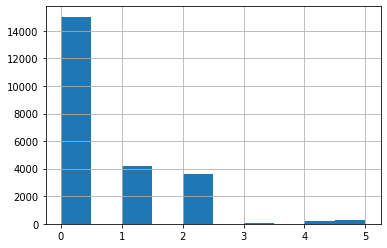

In [55]:
data['balcony'].hist();

**Тоже, ничего не поделать**

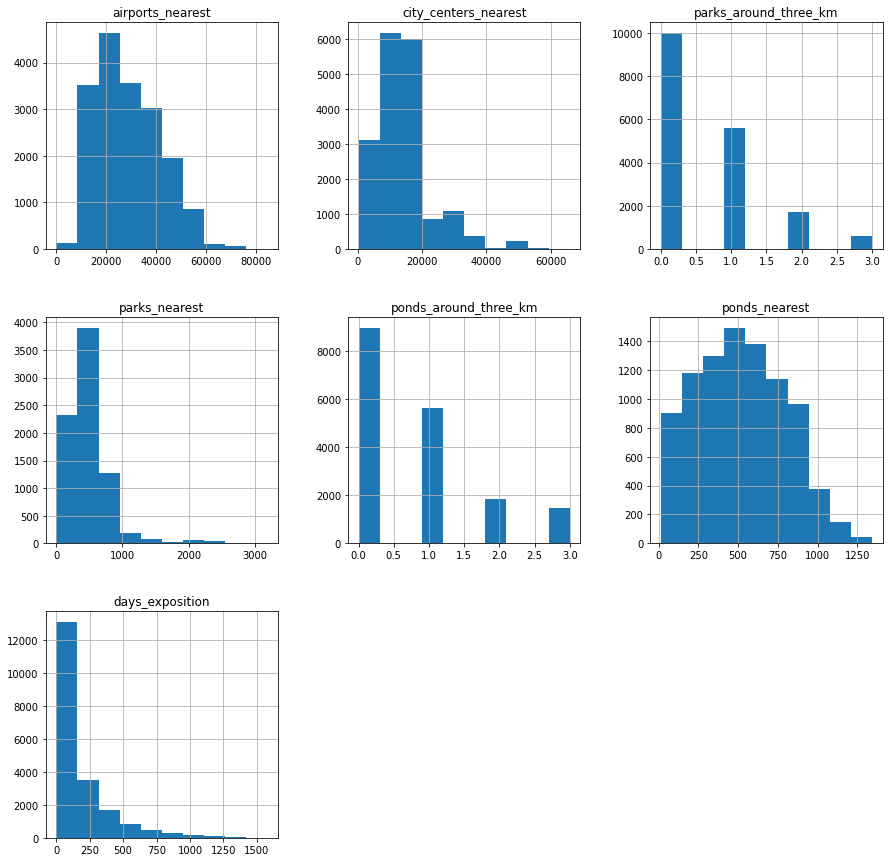

In [56]:
data[list_name].hist(figsize=(15,15));

**Признаки с расстояниями до объектов, в целом, выглядят хорошо, трогать не будем**

**Булевы параметры остаются так как есть, такие как "апартаменты", "студия", "открытая планировка"**
<br>**Дату тоже не изменить, как и количество дней  в продаже**
<br>**С названиями тоже уже всё решено**

**Посмотрим еще раз на данные, сперва сбросив индексацию**

In [57]:
data.reset_index(drop=True,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23397 entries, 0 to 23396
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   total_images           23397 non-null  uint8         
 1   last_price             23397 non-null  float64       
 2   total_area             23397 non-null  float32       
 3   first_day_exposition   23397 non-null  datetime64[ns]
 4   rooms                  23397 non-null  uint8         
 5   ceiling_height         23397 non-null  float32       
 6   floors_total           23397 non-null  uint8         
 7   living_area            21557 non-null  float32       
 8   floor                  23397 non-null  uint8         
 9   is_apartment           23397 non-null  bool          
 10  studio                 23397 non-null  bool          
 11  open_plan              23397 non-null  bool          
 12  kitchen_area           21221 non-null  float32       
 13  b

In [58]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_three_km,parks_nearest,ponds_around_three_km,ponds_nearest,days_exposition
count,23397.000000,2.339700e+04,23397.000000,23397.000000,23397.000000,23397.000000,21557.000000,23397.000000,21221.000000,23397.000000,17886.000000,17907.000000,17908.000000,7924.000000,17908.000000,8933.000000,20251.000000
mean,9.873360,6.154722e+06,59.195232,2.053554,2.694031,10.691499,33.885017,5.883746,10.464621,0.595461,28819.064453,14241.013672,0.606433,491.108521,0.765133,519.733887,180.373703
std,5.675139,6.033835e+06,29.628754,1.019092,0.211571,6.582736,19.241020,4.874023,5.594929,0.961119,12658.304688,8604.595703,0.797681,342.080597,0.935400,277.666840,219.361420
min,0.000000,4.300000e+05,20.000000,0.000000,2.000000,1.000000,10.000000,1.000000,2.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18539.000000,9330.500000,0.000000,288.000000,0.000000,295.000000,45.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26785.500000,13138.000000,0.000000,455.000000,0.000000,504.000000,95.000000
75%,14.000000,6.700000e+06,69.099998,3.000000,2.700000,16.000000,42.099998,8.000000,12.000000,1.000000,37344.750000,16296.000000,1.000000,612.000000,1.000000,733.000000,230.500000
max,50.000000,9.900000e+07,300.000000,7.000000,5.000000,36.000000,250.000000,33.000000,107.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**На самом деле, если бы был адрес, можно было бы заполнить больше пропусков и откинуть меньше данных**
<br>**А так же, если бы разобрался чуть больше в предметной области, можно было бы провести анализ зависимости столбцов и заполнить пропуски относительно новых знаний**


### Посчитайте и добавьте в таблицу новые столбцы

**цена одного квадратного метра**

In [59]:
data['price_square_meter'] = data['last_price'] / data['total_area']

**день недели публикации объявления**

In [60]:
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek

**месяц публикации объявления**

In [61]:
data['month_of_publication'] = data['first_day_exposition'].dt.month

**год публикации объявления**

In [62]:
data['year_of_publication'] = data['first_day_exposition'].dt.year

**тип этажа квартиры**

In [63]:
data['floor_type'] = data.apply(lambda x : 'первый' if (x.floor == 1) 
                                else ('последний' if (x.floor == x.floors_total) 
                                else 'другой'), axis=1)

**перевод из м в км**

In [64]:
data['city_centers_nearest_km'] = (data['city_centers_nearest'] / 1000).round(1)

In [65]:
# изменим тип
data = data.astype({'last_price':'uint32', 
                    'price_square_meter':'float32', 
                    'day_of_week':'uint8', 
                    'month_of_publication':'uint8', 
                    'year_of_publication':'uint16'}, 
                    errors='ignore') 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23397 entries, 0 to 23396
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23397 non-null  uint8         
 1   last_price               23397 non-null  uint32        
 2   total_area               23397 non-null  float32       
 3   first_day_exposition     23397 non-null  datetime64[ns]
 4   rooms                    23397 non-null  uint8         
 5   ceiling_height           23397 non-null  float32       
 6   floors_total             23397 non-null  uint8         
 7   living_area              21557 non-null  float32       
 8   floor                    23397 non-null  uint8         
 9   is_apartment             23397 non-null  bool          
 10  studio                   23397 non-null  bool          
 11  open_plan                23397 non-null  bool          
 12  kitchen_area             21221 n

### Проведите исследовательский анализ данных

In [66]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,parks_around_three_km,parks_nearest,ponds_around_three_km,ponds_nearest,days_exposition,price_square_meter,day_of_week,month_of_publication,year_of_publication,city_centers_nearest_km
count,23397.000000,2.339700e+04,23397.000000,23397.000000,23397.000000,23397.000000,21557.000000,23397.000000,21221.000000,23397.000000,...,17908.000000,7924.000000,17908.000000,8933.000000,20251.000000,23397.000000,23397.000000,23397.000000,23397.000000,17907.000000
mean,9.873360,6.154722e+06,59.195232,2.053554,2.694031,10.691499,33.885017,5.883746,10.464621,0.595461,...,0.606433,491.108521,0.765133,519.733887,180.373703,98398.546875,2.567295,6.403556,2017.372014,14.240984
std,5.675139,6.033835e+06,29.628754,1.019092,0.211571,6.582736,19.241020,4.874023,5.594929,0.961119,...,0.797681,342.080597,0.935400,277.666840,219.361420,42810.941406,1.788115,3.493354,1.036684,8.604205
min,0.000000,4.300000e+05,20.000000,0.000000,2.000000,1.000000,10.000000,1.000000,2.000000,0.000000,...,0.000000,1.000000,0.000000,13.000000,1.000000,7962.962891,0.000000,1.000000,2014.000000,0.200000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,...,0.000000,288.000000,0.000000,295.000000,45.000000,76500.000000,1.000000,3.000000,2017.000000,9.300000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,...,0.000000,455.000000,0.000000,504.000000,95.000000,94861.664062,3.000000,6.000000,2017.000000,13.100000
75%,14.000000,6.700000e+06,69.099998,3.000000,2.700000,16.000000,42.099998,8.000000,12.000000,1.000000,...,1.000000,612.000000,1.000000,733.000000,230.500000,113945.578125,4.000000,10.000000,2018.000000,16.299999
max,50.000000,9.900000e+07,300.000000,7.000000,5.000000,36.000000,250.000000,33.000000,107.000000,5.000000,...,3.000000,3190.000000,3.000000,1344.000000,1580.000000,848484.875000,6.000000,12.000000,2019.000000,66.000000


#### **Рассмотрим следующие параметры квартир**

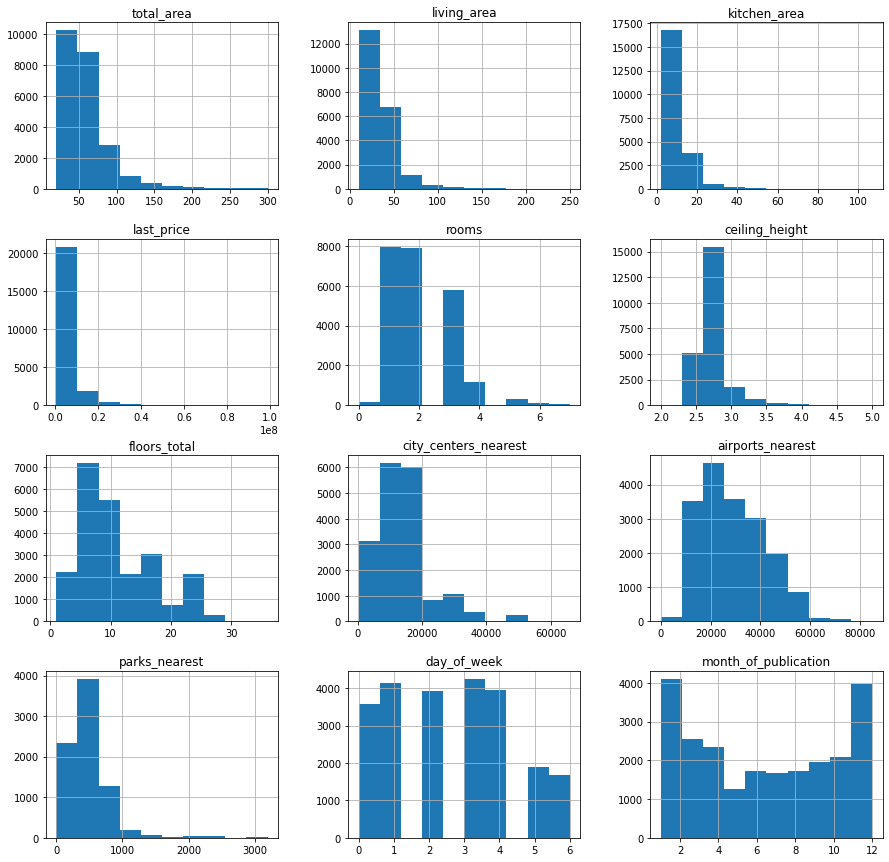

In [67]:
# параметры на рассмотрении перечислены в списке
hist_list = ['total_area', 'living_area', 'kitchen_area', 
             'last_price', 'rooms', 'ceiling_height', 
             'floor_type', 'floors_total', 
             'city_centers_nearest', 'airports_nearest', 'parks_nearest', 
             'day_of_week', 'month_of_publication']

data.hist(hist_list, figsize=(15,15));

**А теперь по порядку:**

**1) На графике видно, что большая часть квартир имеют общую площадь до 75 кв м. Далее идет резкий спад**
<br>**2) Ну и естественно такое же поведение проссматривается для жилой площади и кухни, чем больше общая площадь, тем вероятнее и спален больше и кухня по просторнее**
<br>**3) А поскольку чем больше квадратов, тем стоимость квартиры выше (это без учета района и прочих особенностей строения), график ведет себя таким же образом**
<br>**4) Для самой популярной квадратуры нашей выборки не удивительно, что наиболее популярное количество комнат это от одной до трех**
<br>**5) Про высоту потолков вообще особо смысла говорить нет, поскольку они делаются по ГОСТ-ам, если они не элитная недвижимость . Варируются в районе 2.5 - 3 метров, а разные высоты могут быть из-за того, что кто-то до нятяжных потолков замерил, итд...**
<br>**6) Общее количество этажей выглядит предсказуемо, привет сталинкам и хрущевкам, 5 этажей наше всё. Но к слову и многоэтажных домов мало, это по большей части из-за того, что город расположен на болотах, там небоскребы не популярны, а если быть конкретнее, то местами вовсе запрещены. PS В моем регионе такая же ситуация, город на васюганских болотах, самое большое жилое здание 25 этажей**
<br>**7) Поскольку центр является исторической частью, там квартиры продают реже, поэтому большая часть нашей выборки находится на расстоянии 3км от центра**
<br>**8) Расстояние до аэропорта в целом не большое каких-то 20 км для большей части выборки, что говорит о том, что аэропорт находится близко к городу**
<br>**9) Так же радует, что в основном все живут рядом с парками**
<br>**10) Не удивительно, что в основном объявления о продаже квартир выкладывают в рабочие дни, поскольку основной массой объявлений о продаже занимаются риэлторы. Но интересно, что во вторник и четверг больше всего, а в пн наименьшее значение в будни. Наверно в нечетные дни занимаются поиском новых клиентов, а в четные выкладывают=)**
<br>**11) Еще занимательное наблюдение, с квартирами стараются распращаться в конце и начале года, новый год - новые возможности. Весной какой-то спад, но думаю это от года в год зависит, что к лету падение, а потом рост продаж**
<br>**12) И наконец, тип этажа, как ни страно, больше продаж квартир не последний и не первый этаж. Ну тут конечно элементарно. Если начать продавать весь дом, то к примеру: Есть пятиэтажный дом. В нем 7 подъездов. На каждом этаже подъезда по 2 квартиры. Итого мы получаем 70 квартир. Но при этом на первом, как и на последнем будет всего по 14 квартир. А на остальных этажах 48 квартир. (График из данных представлен ниже)**

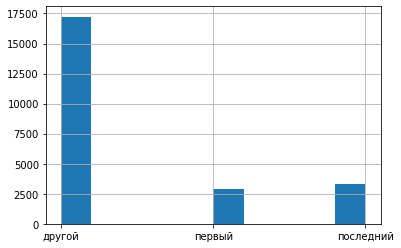

In [68]:
data['floor_type'].hist();

#### **Поговорим о скорости продажи**

In [69]:
data['days_exposition'].agg(['mean', 'median'])

mean      180.373703
median     95.000000
Name: days_exposition, dtype: float64

**Глядя на медиану и среднее можно сделать вывод, что в среднем, квартиры продают по пол года, но медиана сокращает это значение в два раза, из-за растянутых продаж дорогостоющих квартир**

**Вся выборка**

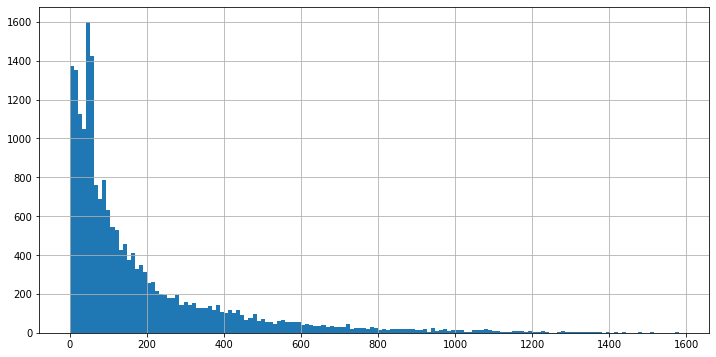

In [70]:
data['days_exposition'].hist(bins=150, figsize=(12,6))
plt.show()


**Выборка до 300 дней продажи**

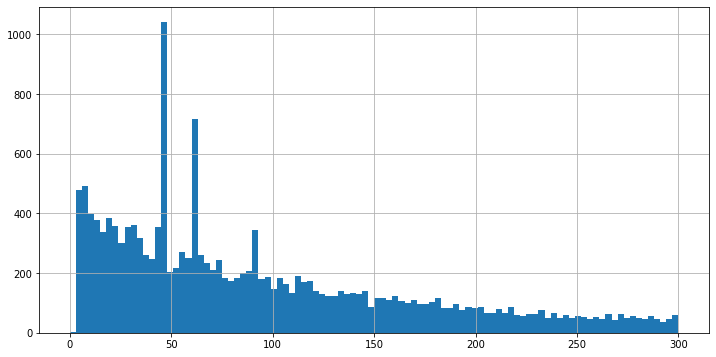

In [71]:
data['days_exposition'].hist(bins=100, figsize=(12,6), range=(0,300))
plt.show()

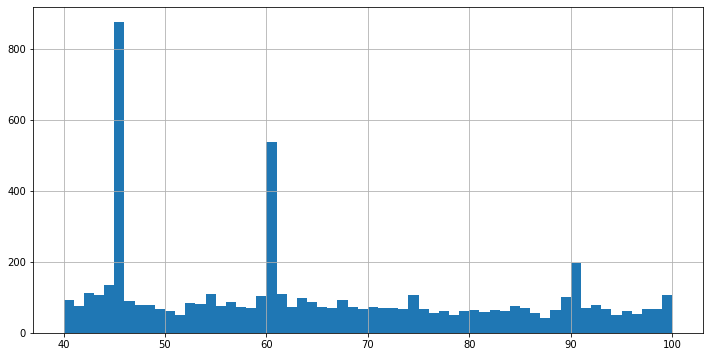

In [72]:
data['days_exposition'].hist(bins=60, figsize=(12,6), range=(40,100))
plt.show()

**Так же есть заметные пики на ровных числах (45, 60, 90). Есть подозрение, что это автоснятие объявления из системы**

#### Факторы влияющие на цену

**Вызовем функицию, показывающую корреляцию**

In [73]:
dict_arg = {'Общая площадь' : 'total_area',
            'Жилая площадь' : 'living_area',
            'Площадь кухни' : 'kitchen_area',
            'Количество комнат' : 'rooms'}

print('Кореляция:')
for i, j in dict_arg.items():
    print(f"Цена <-> {i} : {data['last_price'].corr(data[j]):.2} %")

Кореляция:
Цена <-> Общая площадь : 0.75 %
Цена <-> Жилая площадь : 0.66 %
Цена <-> Площадь кухни : 0.58 %
Цена <-> Количество комнат : 0.45 %


**В целом, результаты очевидны, площадь квартиры имеет наибольший вес**

**Рассмотрим графически**

**1) Начнем с отношения цены и этажа**

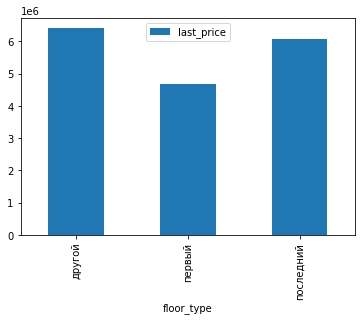

In [74]:
data.pivot_table(index='floor_type',values='last_price').plot(y='last_price', kind='bar');

**Как видим, этаж почти не влияет на стоимость, отметить можно только первый этаж**

**2) Отношение цены и общей площади / жилой площади / кухни**

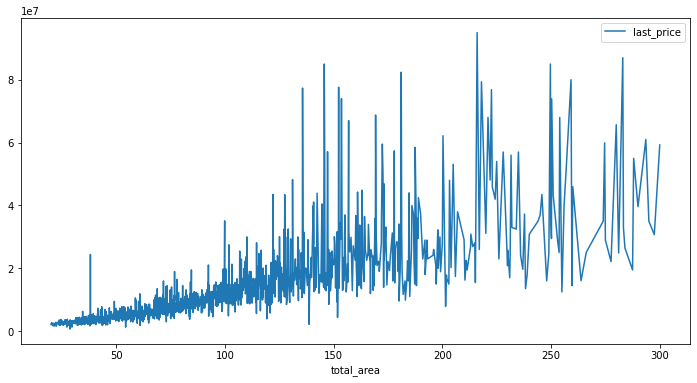

In [75]:
# Начнем с общей площади
data.pivot_table(index='total_area',values='last_price').plot(y='last_price', figsize=(12,6));

**Заметно, как растет отношение цены и общей площади. Скачки говорят о том, что есть еще зависимости. Скорее всего от расстояния до центра**

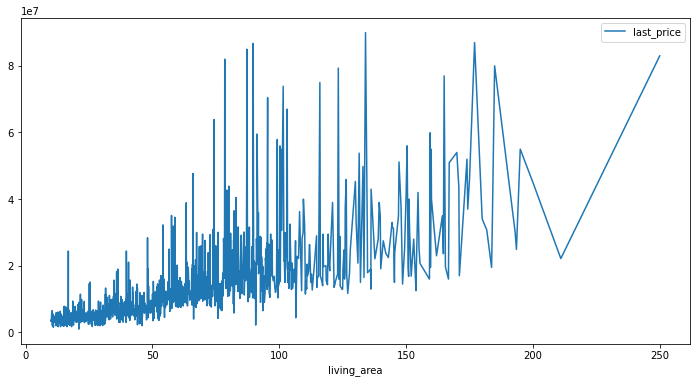

In [76]:
# Жилая площадь
data.pivot_table(index='living_area',values='last_price').plot(y='last_price', figsize=(12,6));

**Такие же выводы и с жилой площадю. Скорее всего кухня не удивит. Разве что выборку можо было еще сделать меньше, по резкому окончанию, значит там мало значений.**

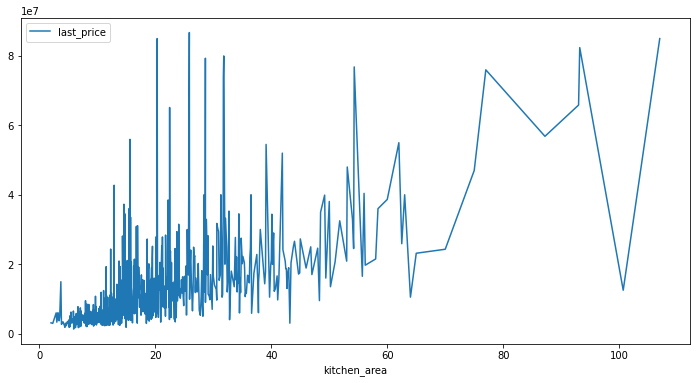

In [77]:
# Площадь кухни
data.pivot_table(index='kitchen_area',values='last_price').plot(y='last_price', figsize=(12,6));

**Кухня большая, как и думали, тоже влияет на цену. Ну концовка тоже резкая из-за малого набора**

**3) Отношение цены и количества комнат**

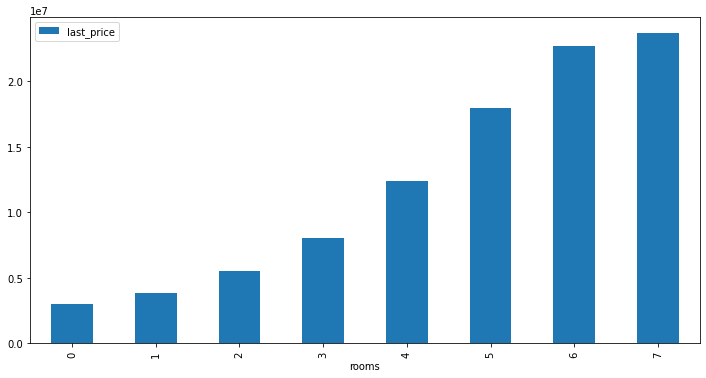

In [78]:
# Количество комнат
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', figsize=(12,6), kind='bar');

**Тут ноги так же растут от большой площади. Чем она больше, тем комнат больше и соответсвенно цена**

**3) Отношение цены и даты**

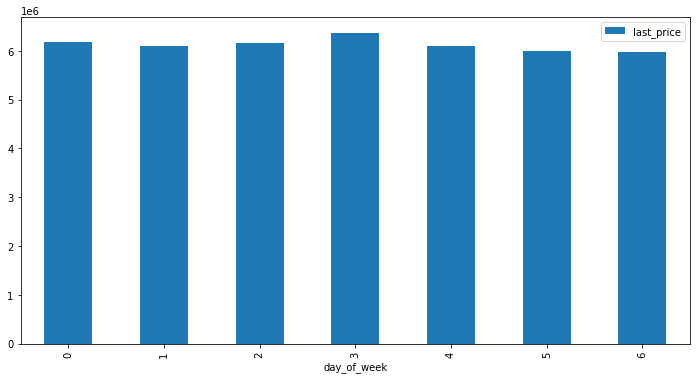

In [79]:
# День недели
data.pivot_table(index='day_of_week',values='last_price').plot(y='last_price', figsize=(12,6), kind='bar');

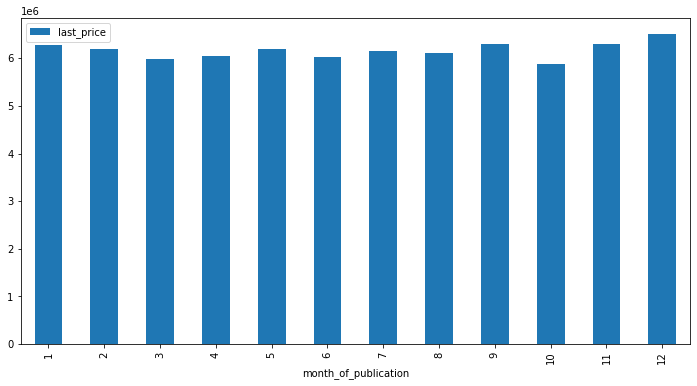

In [80]:
# Месяц
data.pivot_table(index='month_of_publication',values='last_price').plot(y='last_price', figsize=(12,6), kind='bar');

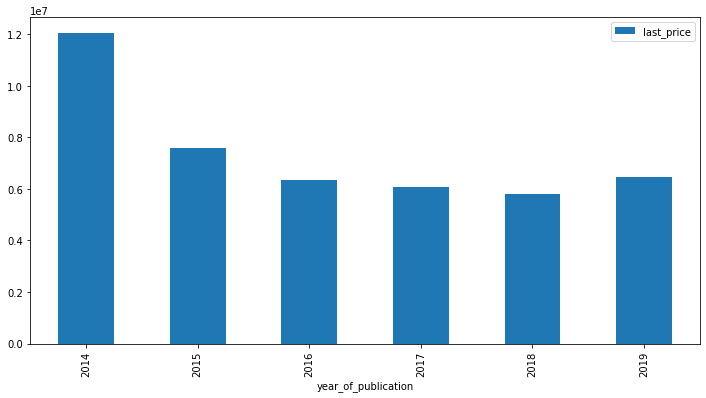

In [81]:
# Год
data.pivot_table(index='year_of_publication',values='last_price').plot(y='last_price', figsize=(12,6), kind='bar');

**Как видим, дата не на что не влияет. Про 14 год молчу.**

#### Посмотрим на среднюю цену в 10 населенных пунктах

In [82]:
# соберем данные в кучку
region_data = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])

In [83]:
# для удобства изменим названия столбцов
region_data.columns = ['last_price_sum','total_area_sum','last_price_count','total_area_count']

In [84]:
# возьмем только населенные пункты с большим количеством объявлений
region_data = region_data.sort_values('last_price_count', ascending=False)[:10]

In [85]:
# считаем среднюю стоимость за квадратный метр
region_data['price_per_square_meter'] = region_data['last_price_sum'] / region_data['total_area_sum']

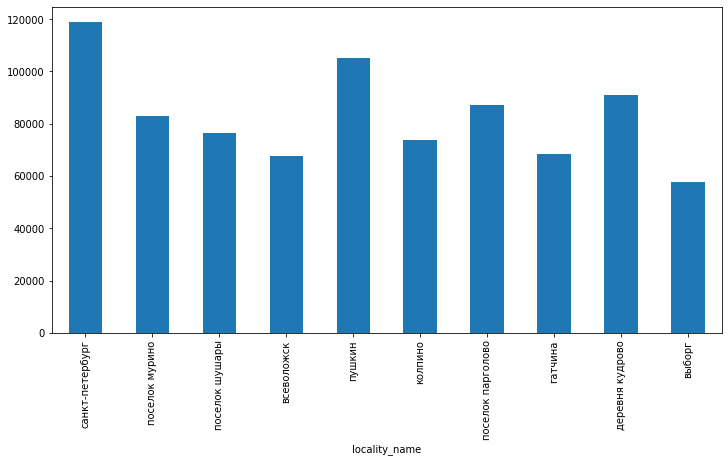

In [86]:
# сторим график
region_data['price_per_square_meter'].plot(kind='bar', figsize=(12,6));

**Выведем на экран населенные пункты с самой низкой и высокой стоимостью за квадратный метр**

In [87]:
# Про первый вывод промолчу
print(f"Населенный пункт с самой высокой стоимостью квадратного метра: {'-'.join(map(lambda x : x.capitalize(), region_data['price_per_square_meter'].idxmax().split('-')))}")
print(f"Населенный пункт с самой низкой стоимостью квадратного метра: {region_data['price_per_square_meter'].idxmin().capitalize()}")

Населенный пункт с самой высокой стоимостью квадратного метра: Санкт-Петербург
Населенный пункт с самой низкой стоимостью квадратного метра: Выборг


**Как видно было из графика, больше всего объявлений в Санк-Петербурге. А меньше всего в топ-10 городов - Выборг.**

#### Теперь рассмотрим среднюю цену каждого километра до центра

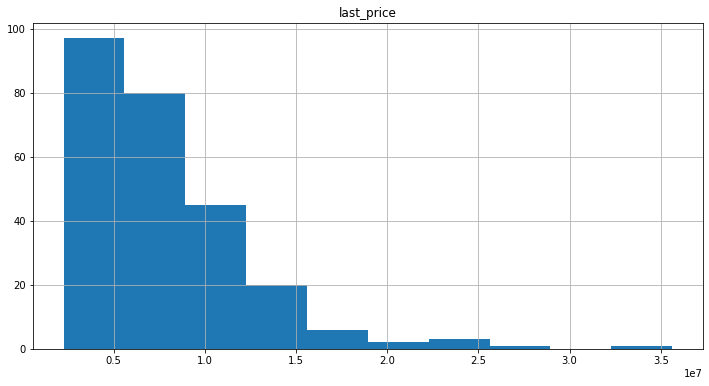

In [88]:
city_centers_data = data[data['locality_name']=='санкт-петербург'].pivot_table(index='city_centers_nearest_km',values='last_price',aggfunc='mean')
city_centers_data.hist(figsize=(12,6));

**Как видим, наибольшую цену за кв метр имеют квартиры с расстояним до киллометра**
<br>**Далее цена падает, только под конец, есть небольшой рост, скорее всего это как-то облагороженный частный сектор**

### Общий вывод

**Подводя итоги:**

**После открытия файла. Предварительно рассмотрев данные обнаружил в 23.6к объектов множество пропусков и аномалий.**
<br>**~Следующим этапом обработал пропуски избавился от аномалий, чтобы достичь более четкую картину для анализа недвижимости Санкт-Петербурга и его области.**
<br>**~Так же избавился от проблемы с типами данных в признаках. И для большей скорости обработки данных понизил разряд.**
<br>**~Так же встретилась проблема с уникальностью названий населенных пунктов, то однозначные названия поселений, то ё и е создают разницу. От которой благополучно избавился.**
<br>**~Как я говорил ранее, что есть некоторые параметры, например, адрес, который по понятным причинам не находится в датасете, могли бы улучшить предобработку данных, в особенности заполнение пропусков. Ну или хотя бы тип постройки, который имеет ГОСТ-ы.**
<br>**~Так же для анализа били созданы отдельные признаки, такие как цена за квадратный метр, разделена дата публикации на составляющие, а также тип этажа.**
<br>**~И переход непосредственно к анализу.  Были изучены основные признаки квартир, которые описаны в пункте 4.1. Из основного это большая часть квартир в продаже имеет не более 75 кв м. и много пятиэтажек. И стараются продавать квартиры в конце или начале года.**
<br>**~Если говорить про скорость продаж, то в среднем квартиры продаются по полгода. Но медианное значение говорит, что чаще всего успевают продавать недвижимость за 3 месяца.**
<br>**~Основное влияние на ценообразование квартиры это естественно ее площадь, чем больше площадь – тем дороже. Хотя стоимость квадрата может быть на меньшую площадь выше, чем у квартиры с большей площадью. Так же посчитав стоимость квадрата относительно расстояния до центра, так же можно заметить, как цена увеличивается с близостью к центру. Там же и был сделан вывод о том, что в Санкт-Петербурге стоимость квадрата выше, чем в населенных пунктах в области. Но чем ближе к Питеру населенный пункт, тем квартиры там дороже.**
